In [1]:
import io
from PIL import Image
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import json
from torchvision.transforms import Compose, Normalize, ToTensor

In [2]:
labels_file = 'imagenet-simple-labels.json'
image_file = 'test.jpg'

In [3]:
net = models.resnet50(pretrained=True)
net.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# 换种方式查看
# for name, parameters in net.named_parameters():
#         print(name, ':', parameters.size())

In [5]:
# cnt = 0
# for name, module in net.named_modules():
#         if isinstance(module, torch.nn.Conv2d):
#             cnt += 1
#             print(name, ":", module)
# print(cnt)

In [6]:
print(net.layer4[2].conv3)

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = []
        self.activations = []

        # 获取forward时target_layer的输出
        target_layer.register_forward_hook(self.save_activation)
        # 获取backward时target_layer的梯度
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        self.gradients = [grad_output[0]] + self.gradients


    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

In [8]:
class BaseCAM:
    def __init__(self, model, target_layer, use_cuda=False):
        self.model = model.eval()
        self.target_layer = target_layer
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.activations_and_grads = ActivationsAndGradients(self.model, target_layer)

    def forward(self, input_img):
        return self.model(input_img)

    def get_cam_weights(self,
                        input_tensor,
                        target_category,
                        activations,
                        grads):
        raise Exception("Not Implemented")

    def get_loss(self, output, target_category):
        return output[:, target_category]

    def __call__(self, input_tensor, target_category=None, is_whole=True):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        # model计算结果（score*12）
        output = self.activations_and_grads(input_tensor)
        # print('output', output)

        # 找出score最大的index作为target category
        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())
            print('==>', target_category)

        # 把模型参数的梯度设为0
        self.model.zero_grad()
        # 利用index取出score作为loss
        loss = self.get_loss(output, target_category)
        # print('loss', loss)
        loss.backward(retain_graph=True)

        # 获取forward激活
        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0, :]
        # print('activations', activations)
        # 获取backward梯度
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0, :]
        # print('grads', grads)

        # 用target layer的梯度mean作为每一层feature map的weight（shape即为fm层数）
        weights = self.get_cam_weights(input_tensor, target_category, activations, grads)
        # print('weights', weights.shape)

        if is_whole:
            return self.cam_whole(activations, weights)
        else:
            return self.cam_part(activations, weights)

    def cam_whole(self, activations, weights):
        # 定义一个和feature map大小一致的cam（size*size）
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        # 用每一层的weight去乘每一层fm的激活（输出）再叠加在一起
        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        # 将cam中的负值都变为0（类似于ReLU)
        cam = np.maximum(cam, 0)
        # # 将cam resize为输入图的大小
        # cam = cv2.resize(cam, input_tensor.shape[2:][::-1])
        # 对cam的值进行标准化（0-1）
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

    def cam_part(self, activations, weights):
        cams = np.zeros(activations.shape, dtype=np.float32)
        for i, w in enumerate(weights):
            # 用每一层的weight去乘每一层fm的激活（输出）
            cam = w * activations[i, :, :]

            # 将cam中的负值都变为0（类似于ReLU)
            cam = np.maximum(cam, 0)

            cams[i] = cam

        cams_min = np.min(cams)
        cams_max = np.max(cams)

        for i, cam in enumerate(cams):
            # 对每一层cam的值进行标准化（0-1）
            cam = cam - np.min(cams_min)
            cam = cam / np.max(cams_max)

            cams[i] = cam
        return cams

class GradCAM(BaseCAM):
    def __init__(self, model, target_layer, use_cuda=False):
        super(GradCAM, self).__init__(model, target_layer, use_cuda)

    def get_cam_weights(self, input_tensor,
                        target_category,
                        activations, grads):
        return np.mean(grads, axis=(1, 2))

In [9]:
def show_cam_on_image(img: np.ndarray, mask: np.ndarray, is_whole=True, with_img=True) -> np.ndarray:
    if is_whole:
        mask = cv2.resize(mask, img.shape[0:2])
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        if with_img:
            heatmap = np.float32(heatmap) / 255
            cam = heatmap + np.float32(img)
            cam = cam / np.max(cam)
            return np.uint8(255 * cam)
        else:
            print(heatmap.shape)
            return heatmap
    else:
        results = np.zeros((mask.shape[0], img.shape[0], img.shape[1], img.shape[2]))
        for i, m in enumerate(mask):
            m = cv2.resize(m, img.shape[0:2])
            heatmap = cv2.applyColorMap(np.uint8(255 * m), cv2.COLORMAP_JET)
            if with_img:
                heatmap = np.float32(heatmap) / 255
                cam = heatmap + np.float32(img)
                cam = cam / np.max(cam)
                results[i] = np.uint8(255 * cam)
            else:
                results[i] = heatmap
        return results

In [10]:
def image_process(image_path):
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465),
                  (0.2023, 0.1994, 0.2010))
    ])(rgb_img).unsqueeze(0)
    return input_tensor, rgb_img

In [11]:
def label_process(class_name):
    with open(labels_file) as f:
        classes = json.load(f)
        
    class_dic = {classes[i]: i for i in range(len(classes))}

    label = class_dic[class_name]
    return label

In [12]:
def grad_cam(model, module, image_path, class_name):
    is_whole = True

    cam = GradCAM(model=model,
                  target_layer=module,
                  use_cuda=True)

    input_tensor, rgb_img = image_process(image_path)
    target_category = label_process(class_name)

    grayscale_cam = cam(input_tensor=input_tensor,
                        target_category=target_category,
                        is_whole=is_whole)

    cam_image = show_cam_on_image(img=rgb_img,
                                  mask=grayscale_cam,
                                  is_whole=is_whole,
                                  with_img=is_whole)
    return cam_image

In [13]:
img_path = "test.jpg"
# 修改下面的module参数可以可视化任一层
cam = grad_cam(model=net, module=net.layer4[2].conv3, image_path=img_path , class_name='mountain bike')

In [14]:
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

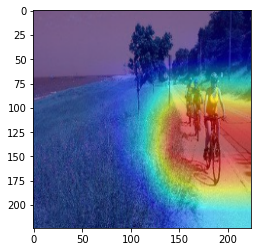

In [15]:
plt.imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))